In [79]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sn
import requests
import statsmodels.tsa.stattools as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.rolling import RollingOLS
from matplotlib.pyplot import figure
from bs4 import BeautifulSoup

In [80]:
def getTickers(industry):
    url = f"https://finance.yahoo.com/sectors/{industry.lower()}/"
    webData = requests.get(url)
    soup = BeautifulSoup(webData.content,'html.parser')
    rows = soup.find_all('span',class_="symbol yf-ravs5v")
    ticker = []
    for row in rows: 
       ticker.append(row.text)
    return ticker[:10]

In [81]:
industry = "energy"
tickers = getTickers(industry)

In [82]:
histData = yf.download(tickers,start='2023-01-01',end='2023-12-31')['Adj Close']
prices = pd.DataFrame(histData)
prices

[*********************100%%**********************]  10 of 10 completed


Ticker,COP,CVX,EOG,EPD,ET,MPC,PSX,SLB,TXGE,XOM
Date,,,,,,,,,,
2023-01-03,106.875389,163.949615,116.088104,21.290760,9.929296,107.340248,95.663033,49.919868,1713.020020,100.414597
2023-01-04,107.083229,162.206390,116.004150,21.387421,9.963477,107.011230,95.331627,50.113731,1778.579956,100.706863
2023-01-05,110.323883,165.127502,116.022812,21.642239,10.194193,111.995018,97.547333,51.053967,1778.959961,102.960098
2023-01-06,111.703300,166.371323,118.905197,21.967354,10.382182,113.049858,100.084946,52.827820,1805.920044,104.204552
2023-01-09,110.881310,165.070938,119.166389,22.248537,10.518903,112.024063,96.590988,53.932838,1781.420044,102.262459
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,115.254379,147.925827,119.661530,24.691080,12.933627,149.428101,132.048859,52.444988,1890.900024,99.358162
2023-12-26,116.586571,149.257706,121.648232,24.804688,12.952427,150.626541,133.683945,53.037807,NaN,99.582397
2023-12-27,116.067413,148.768051,121.618874,24.814156,12.961826,148.447571,132.679260,52.395580,1902.729980,99.114418


<Axes: xlabel='Ticker', ylabel='Ticker'>

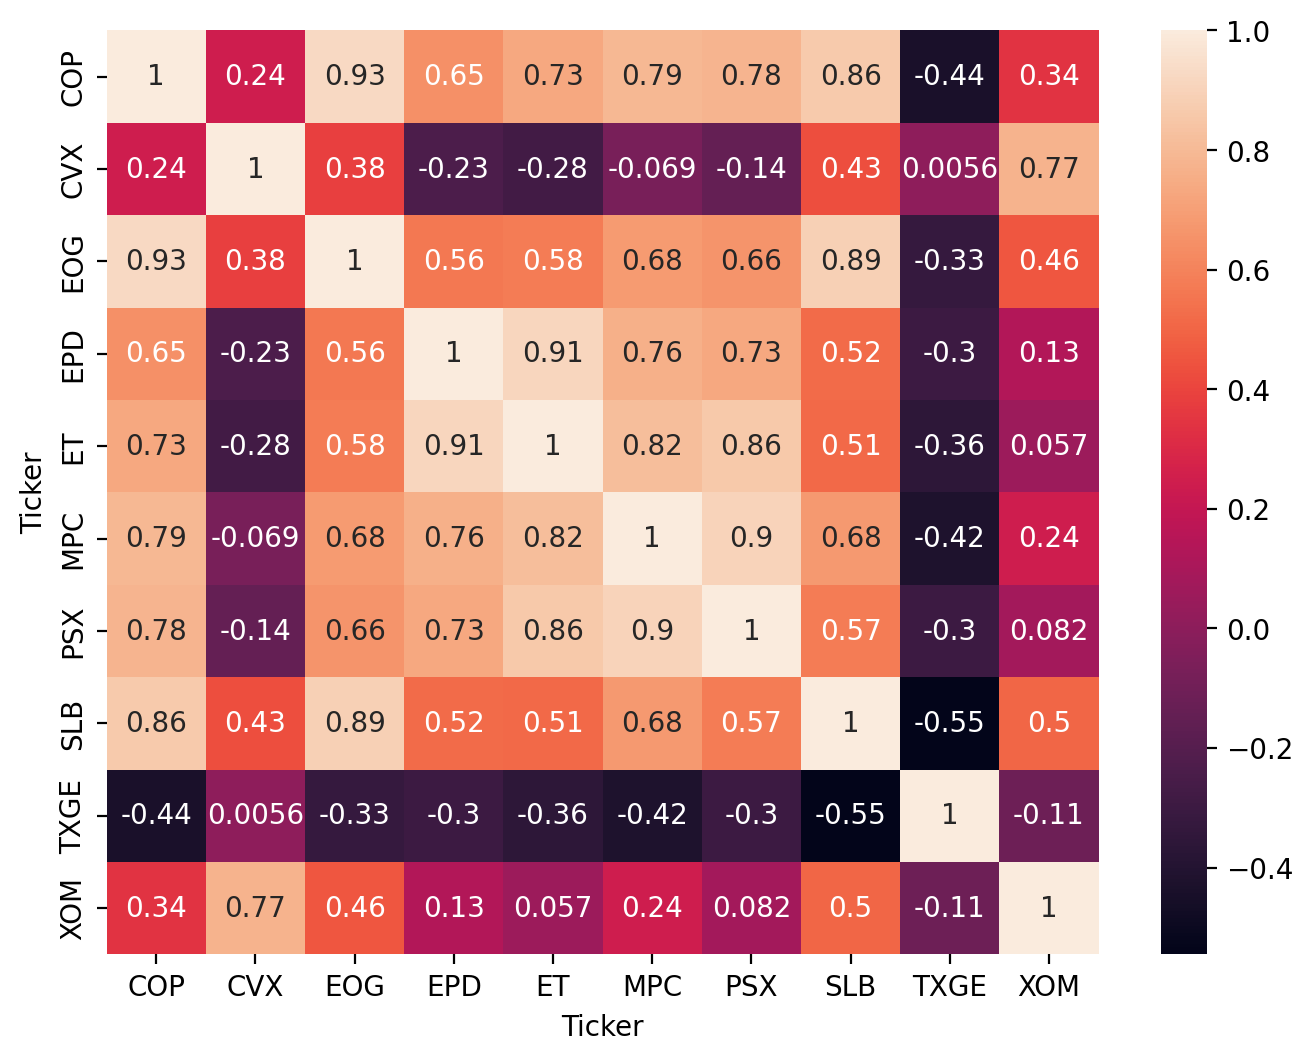

In [83]:
corMtrx = prices.corr()
figure(figsize=(8,6), dpi=200)
sn.heatmap(corMtrx,annot=True)

In [84]:
np.fill_diagonal(corMtrx.values, np.nan)
mxValue = corMtrx.max().max()
mxPair = corMtrx.stack().idxmax()
mxPair

('COP', 'EOG')

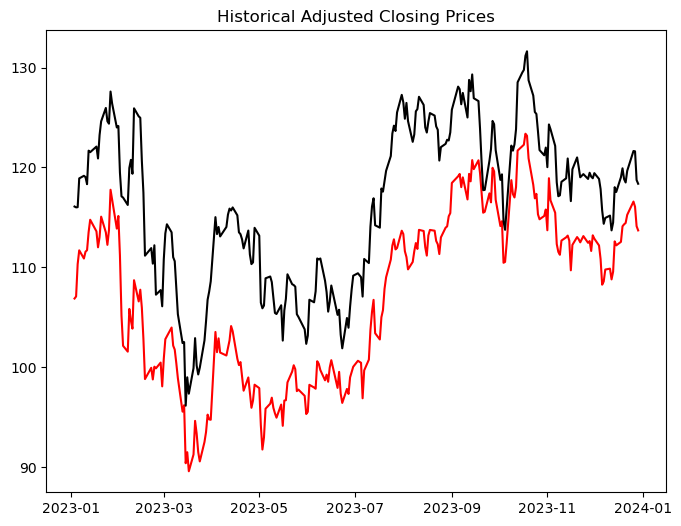

In [85]:
figure(figsize=(8,6), dpi=100)
a = prices[mxPair[0]]
b = prices[mxPair[1]]
plt.plot(a,label=mxPair[0],color='Red')
plt.plot(b,label=mxPair[1],color='Black')
plt.title('Historical Adjusted Closing Prices')
plt.show()

Text(0.5, 1.0, 'Spread between COP and EOG')

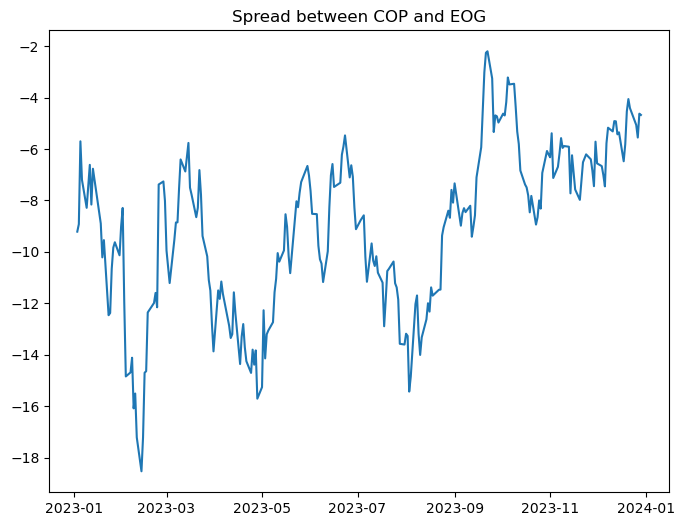

In [86]:
figure(figsize=(8,6), dpi=100)
plt.plot(a-b)
plt.title(f'Spread between {mxPair[0]} and {mxPair[1]}')

In [87]:
ci = sm.coint(a,b)
pVal = ci[1]
print("A p-Value less than 0.05 indicates there exists a cointegration between the two stock prices")
print(f"p-Value for {mxPair[0]} and {mxPair[1]} is:",pVal)

A p-Value less than 0.05 indicates there exists a cointegration between the two stock prices
p-Value for COP and EOG is: 0.2693289270834238


In [88]:
ab_spread_adf = adfuller(a-b)
print("p-Value of the ADF test for the spread is:",ab_spread_adf[1])

p-Value of the ADF test for the spread is: 0.1039462336617234


Text(0.5, 1.0, 'Price Spread between COP and EOG')

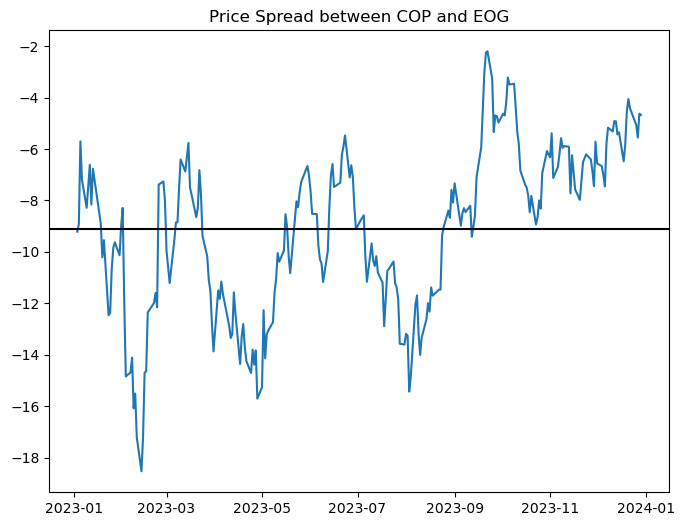

In [89]:
figure(figsize=(8,6), dpi=100)
spread = a-b
plt.plot(spread)
plt.axhline(spread.mean(),color='black')
plt.title(f"Price Spread between {mxPair[0]} and {mxPair[1]}")

Text(0.5, 1.0, 'Z score of Spread')

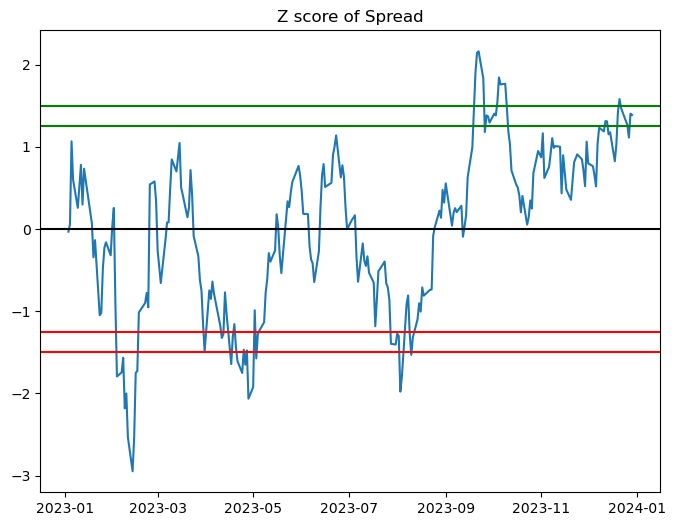

In [90]:
figure(figsize=(8,6), dpi=100)
zsc = (spread-spread.mean())/spread.std()
plt.plot(zsc)
plt.axhline(zsc.mean(),color = 'black')
plt.axhline(-1.25,color = 'red')
plt.axhline(-1.50,color = 'red')
plt.axhline(1.25,color = 'green')
plt.axhline(1.50,color = 'green')
plt.title("Z score of Spread")

Text(0, 0.5, 'Spread')

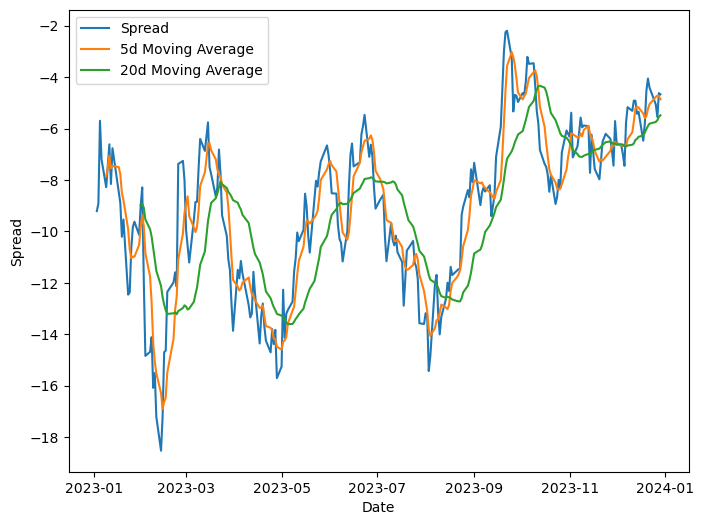

In [91]:
figure(figsize=(8,6), dpi=100)
ma5 = spread.rolling(window=5,center=False).mean()
ma20 = spread.rolling(window=20,center=False).mean()
sd20 = spread.rolling(window=20,center=False).std()
zsc_ma = (ma5-ma20)/sd20
plt.plot(spread.index,spread.values)
plt.plot(ma5.index,ma5.values)
plt.plot(ma20.index,ma20.values)
plt.legend(["Spread","5d Moving Average","20d Moving Average"])
plt.xlabel("Date")
plt.ylabel("Spread")

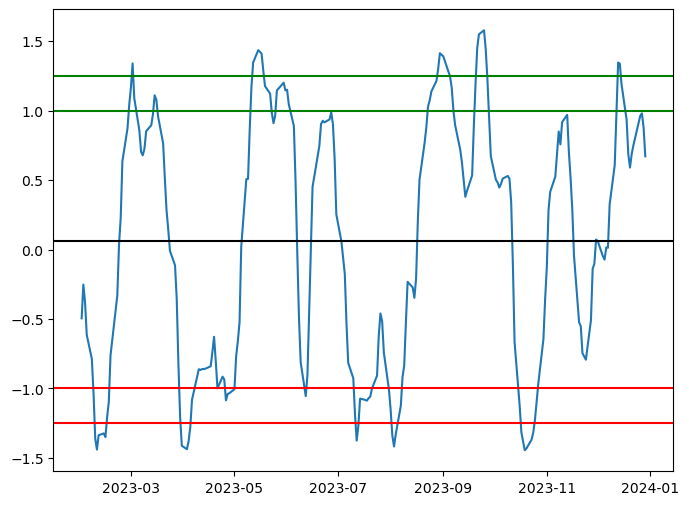

In [92]:
figure(figsize=(8,6), dpi=100)
plt.plot(zsc_ma)
plt.axhline(zsc_ma.mean(),color = 'black')
plt.axhline(-1.25,color = 'red')
plt.axhline(-1.0,color = 'red')
plt.axhline(1.0,color = 'green')
plt.axhline(1.25,color = 'green')

Text(0.5, 1.0, 'Spread of COP and EOG')

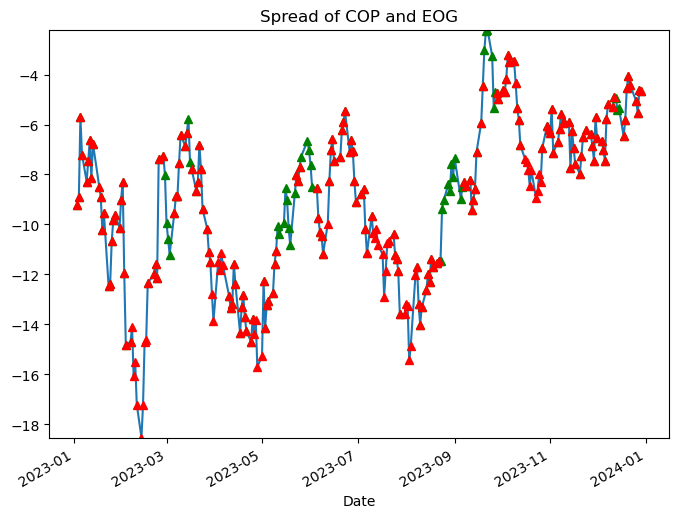

In [93]:
figure(figsize=(8,6), dpi=100)
spread.plot()
long = spread.copy()
short = spread.copy()
long[zsc_ma<-1.0] = 0
short[zsc_ma>1.0] = 0
long.plot(color='g',linestyle = 'None',marker='^')
short.plot(color='r',linestyle = 'None',marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,spread.min(),spread.max()))
plt.title(f'Spread of {mxPair[0]} and {mxPair[1]}')